In [1]:
import numpy as np
from unc_tools import UncRegression


In [2]:
x = np.linspace(0,10,100) + np.random.uniform(low=-.05, high=.05, size= 100)
y = 5 * np.linspace(0,10,100) + 3 + np.random.uniform(low=-.05, high=.05, size= 100)

reg = UncRegression(x,y)

reg.coefs

array([5.012534391945915+/-0.005131359985039762,
       2.9374749066714014+/-0.029681338592283744], dtype=object)

<Axes: >

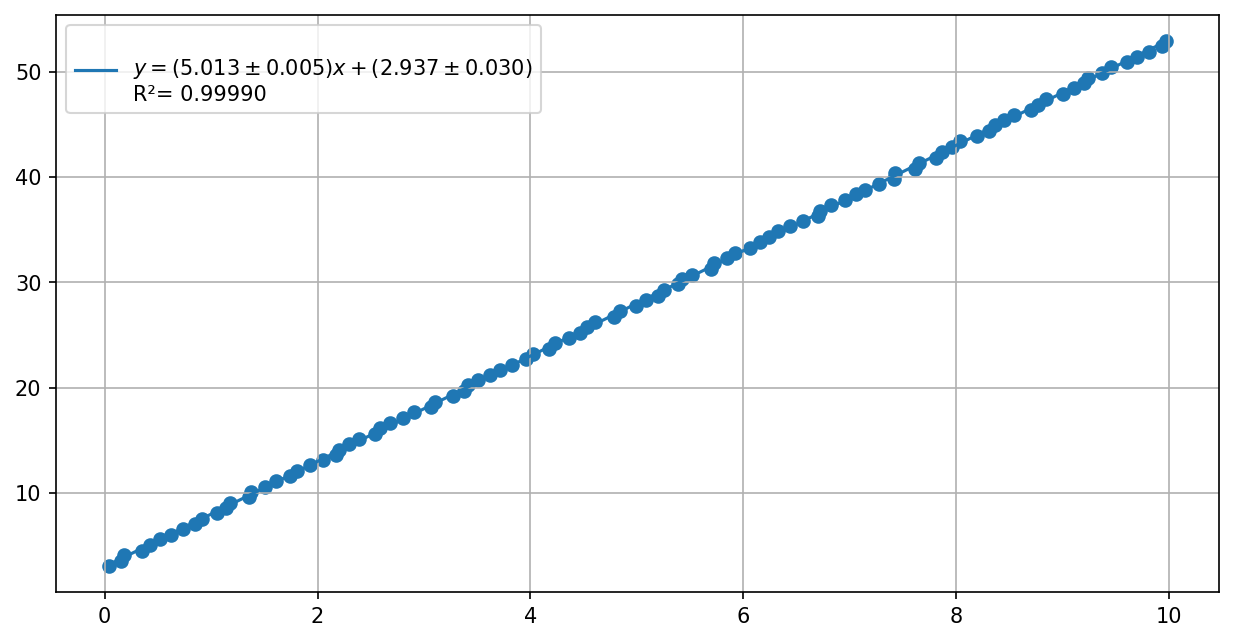

In [3]:
reg.plot()

4.397+/-0.007 4.397+/-0.008
4.40+/-0.20 4.40+/-0.20


<ErrorbarContainer object of 3 artists>

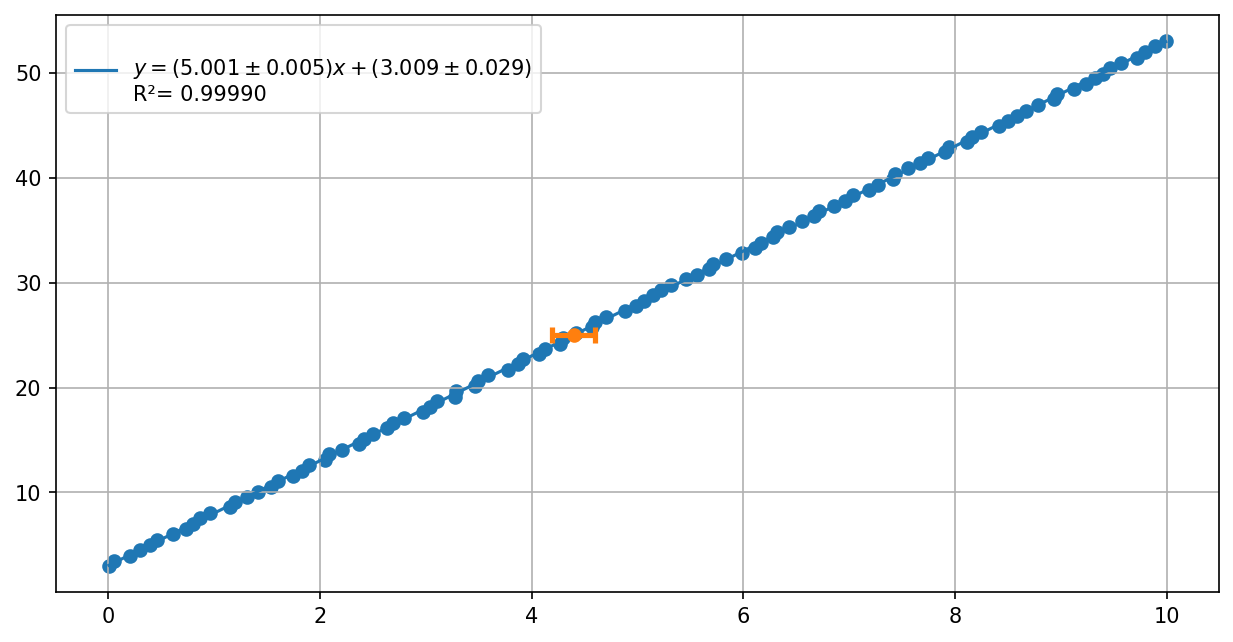

In [4]:
import uncertainties as unc
import matplotlib.pyplot as plt
import unc_tools.patches

x = np.linspace(0,10,100) + np.random.uniform(low=-.05, high=.05, size= 100)
y = 5 * np.linspace(0,10,100) + 3 + np.random.uniform(low=-.05, high=.05, size= 100)

reg = UncRegression(x,y)

y0 = 25
x0_1 = reg.find_x(y0)
x0_2 = reg.find_x(y0, x0 = 5, solve_numerically=True)
print(x0_1, x0_2)


y0 = unc.ufloat(25,1)
x0_1 = reg.find_x(y0)
x0_2 = reg.find_x(y0, x0 = 5, solve_numerically=True)
print(x0_1, x0_2)

ax = reg.plot()
ax.scatter([x0_1],[y0])


y = 25:  [-4.447449907143146+/-0.3731159280262182, 1.0944584305722012+/-0.08068901180562853] 1.09+/-0.19
y = 25.000+/-0.010:  [] 1.09+/-0.19


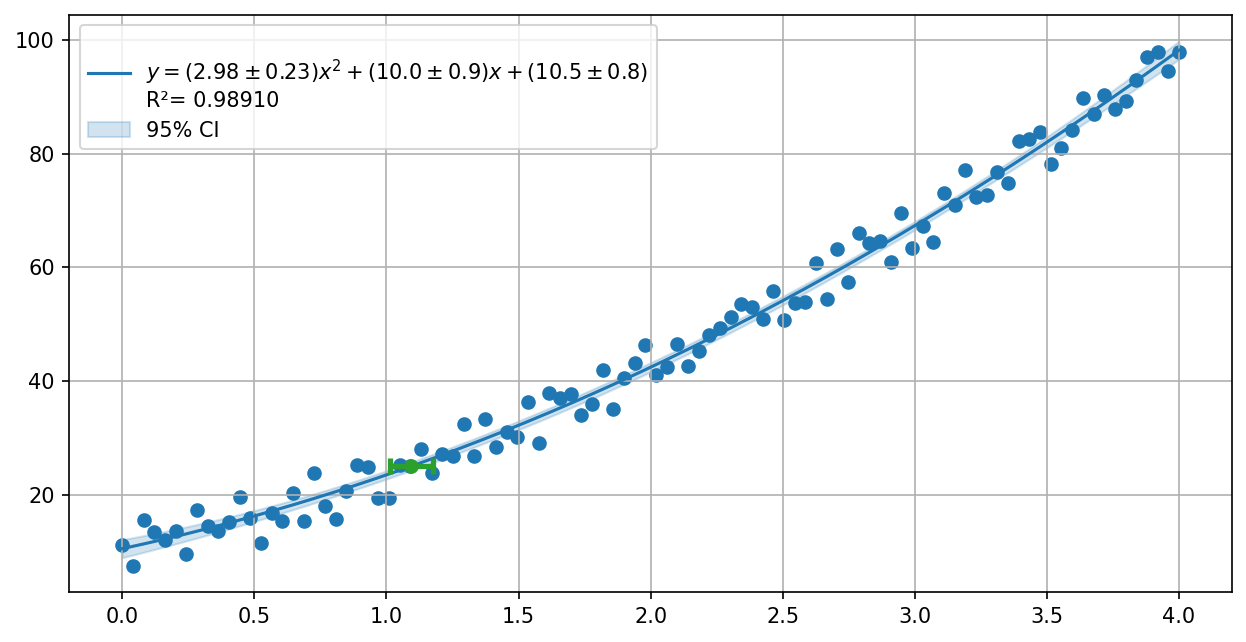

In [30]:
import uncertainties as unc
import matplotlib.pyplot as plt
import unc_tools.patches
from unc_tools import Poly

noise = np.random.uniform(low=-5, high=5, size= 100)
def f(x):
    return 3 * x **2 + 10 * x + 10 + noise
x = np.linspace(0,4,100) 
y = f(x) 

reg = UncRegression(x,y, func=Poly(2))
ax = reg.plot(show_band=True)

y0 = 25
x0_1 = reg.find_x(y0)
x0_2 = reg.find_x(y0, x0 = 5, solve_numerically=True)
print(f"y = {y0}: ",x0_1, x0_2)
ax.scatter([x0_1[1]],[y0])

y0 = unc.ufloat(25,0.01)
x0_1 = reg.find_x(y0)
x0_2 = reg.find_x(y0, x0 = 5, solve_numerically=True)
print(f"y = {y0}: ",x0_1, x0_2)

df = reg.to_df()

In [22]:
import pandas as pd

df = pd.DataFrame({})

df["y"] = y 
x_ = reg.find_x(y_)
df["x1"] = x_[:,0]
df["x2"] = x_[:,1]

df

,y,x1,x2
0,9.961599,-2.9+/-0.4,-0.07+/-0.09
1,10.358983,-2.9+/-0.4,-0.03+/-0.09
2,11.101792,-3.0+/-0.4,0.05+/-0.08
3,14.848738,-3.37+/-0.34,0.40+/-0.07
4,14.079568,-3.31+/-0.34,0.33+/-0.07
...,...,...,...
95,90.753359,-6.8+/-0.4,3.79+/-0.14
96,98.584292,-7.0+/-0.4,4.02+/-0.15
97,98.086311,-7.0+/-0.4,4.01+/-0.15
98,92.684210,-6.8+/-0.4,3.85+/-0.14


<ErrorbarContainer object of 3 artists>

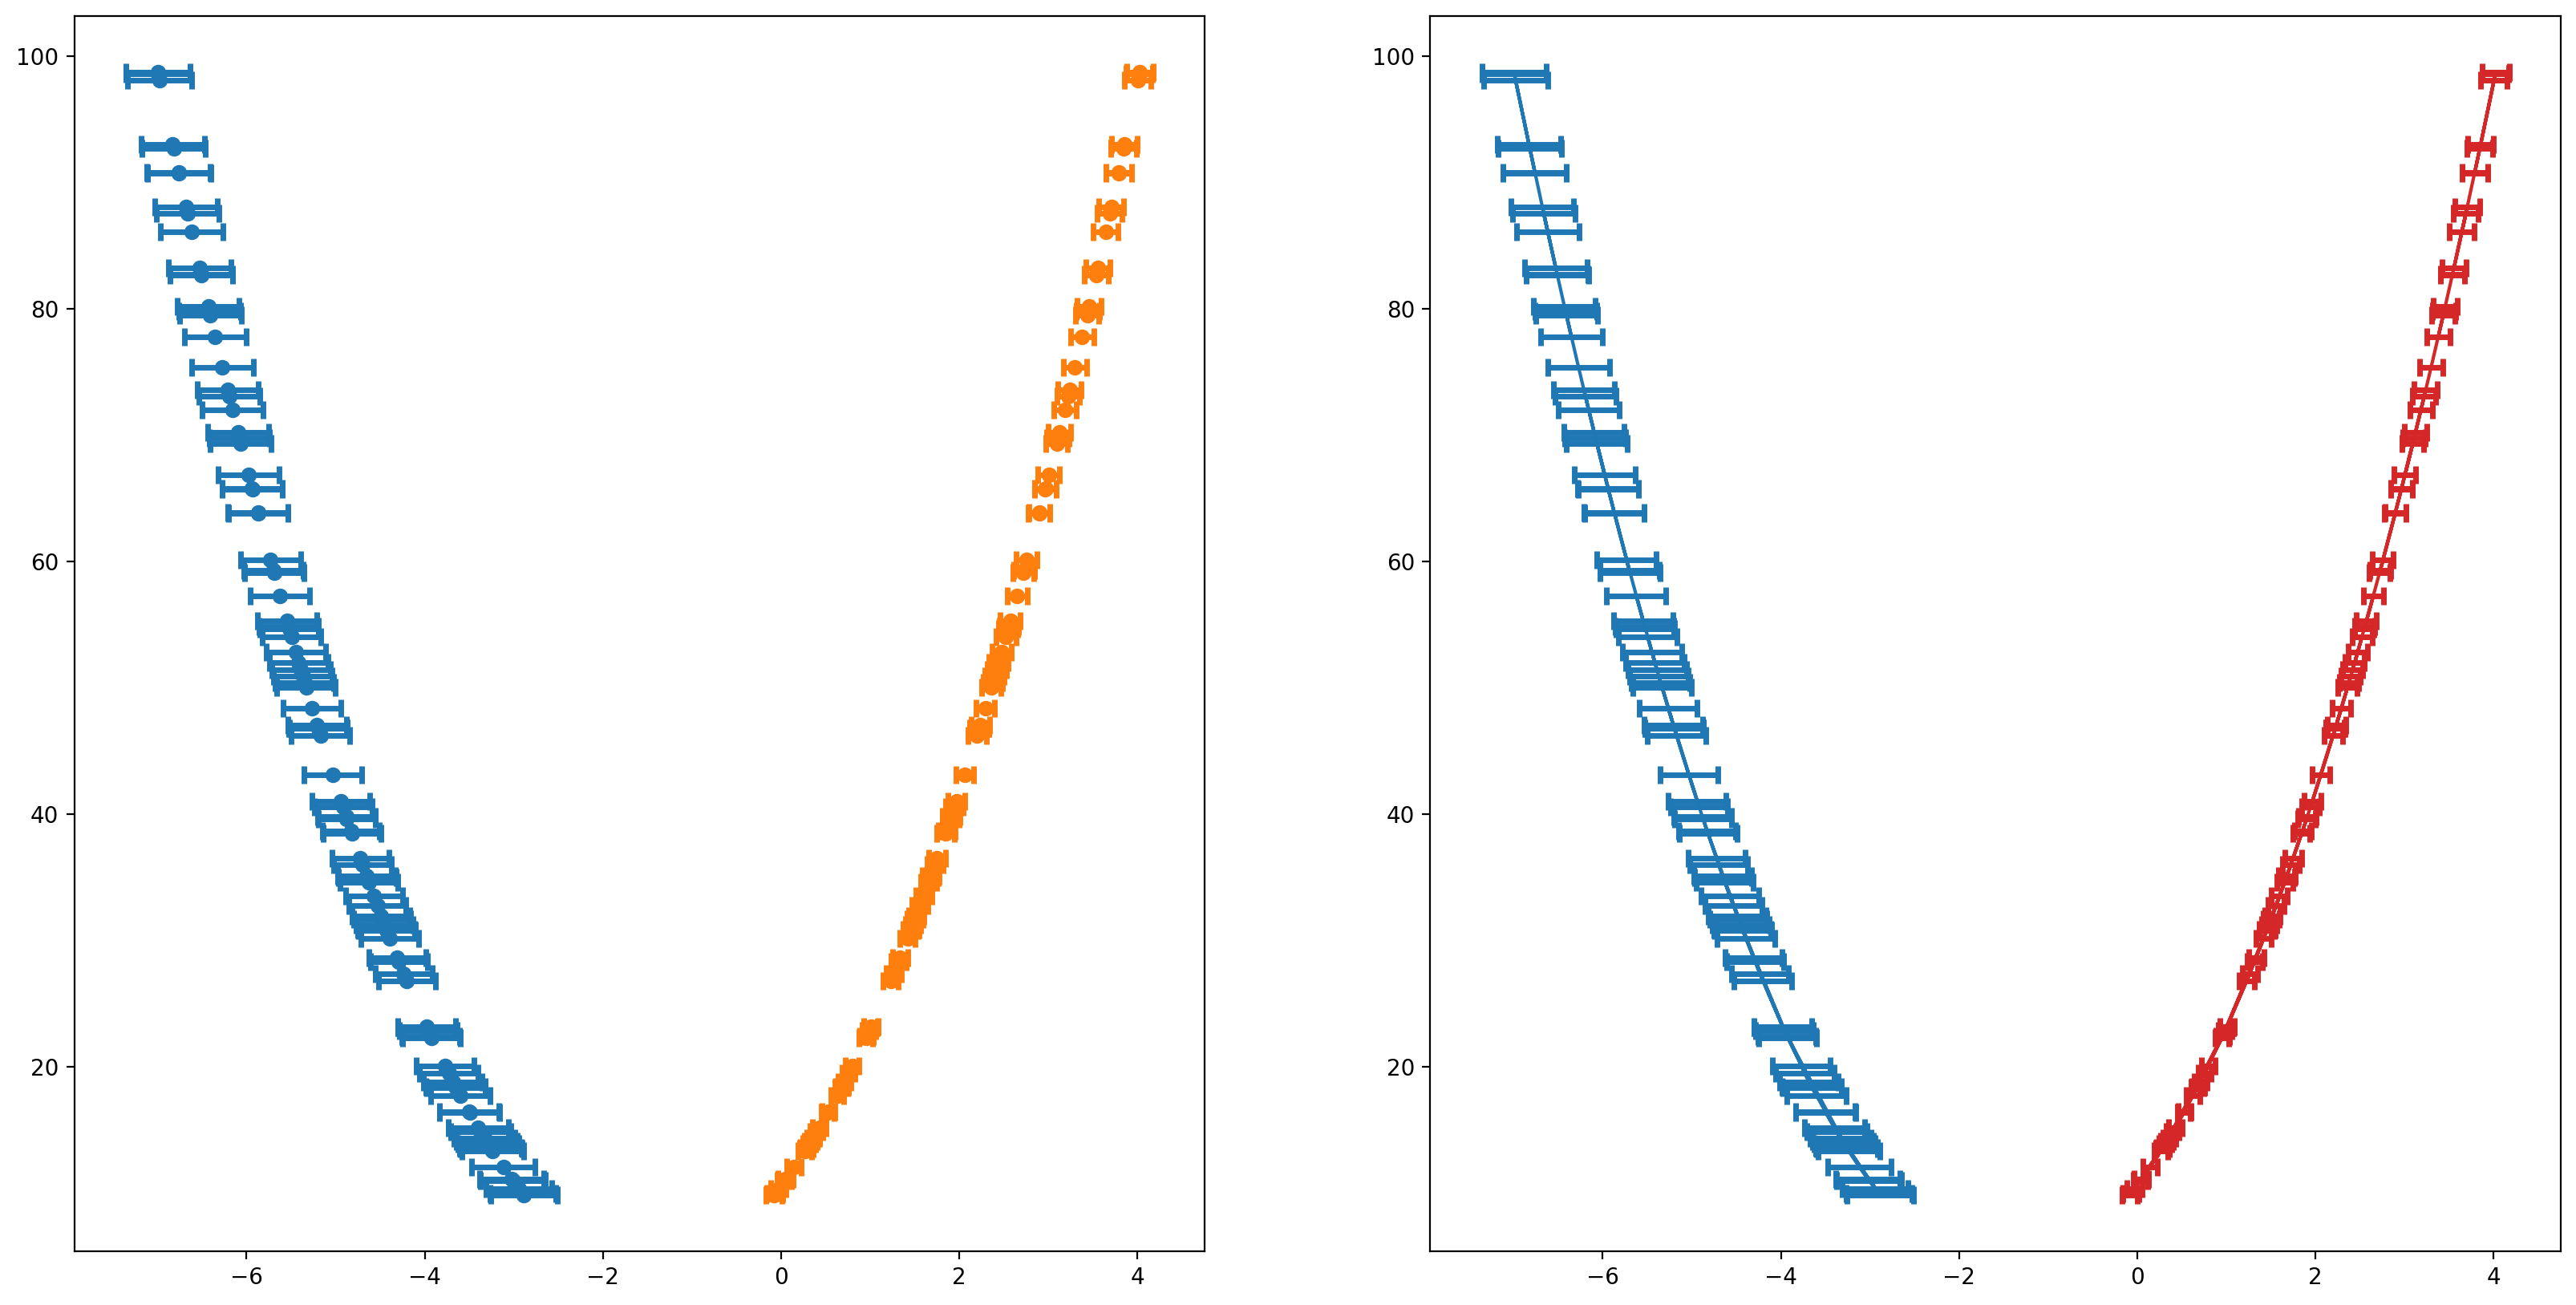

In [28]:
fig, axes = plt.subplots(1,2, figsize=(20,10), dpi=200)

axes[0].scatter(df.x1,df.y)
axes[0].scatter(df.x2,df.y)

axes[1].plot(df.x1,df.y)
axes[1].plot(df.x2,df.y)